In [10]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.stats import entropy
from collections import defaultdict
import argparse
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm

## ActiveLearningPipeline Class

In [33]:
class ActiveLearningPipeline:
    def __init__(self, model,
                 available_pool_indices,
                 train_indices,
                 test_indices,
                 selection_criterion,
                 iterations,
                 budget_per_iter,
                 nodes_df_path,
                 subject_mapping_path):
        self.model = model
        self.iterations = iterations
        self.budget_per_iter = budget_per_iter
        self.nodes_df_path = nodes_df_path
        self.available_pool_indices = available_pool_indices
        self.train_indices = train_indices
        self.test_indices = test_indices
        self.selection_criterion = selection_criterion
        self.nodes_df = pd.read_csv(nodes_df_path)
        self.feature_vectors = self._read_feature_vectors()
        self.labels = self._read_labels(subject_mapping_path)
        self.index_dict = {id: i for i, id in enumerate(self.nodes_df['nodeId'])}
        self.train_indices = np.array([self.index_dict[id] for id in self.train_indices])
        self.test_indices = np.array([self.index_dict[id] for id in self.test_indices])
        self.available_pool_indices = np.array([self.index_dict[id] for id in self.available_pool_indices])
        self.train_labels = self.labels[self.train_indices]
        # TODO: Implement the rest of the constructor and the method run_pipeline (this method should not be called in the constructor, but from outside the class)
        # TODO: You are allowed to add more class methods if needed, but a class method cannot be longer than 15 lines of code
        # TODO: Do not change the constructor signature and the already implemented methods
        self.model_object = self._choose_model(model)

    def _choose_model(self, model_name):
        """
        Choose the model to be used in the active learning pipeline
        """
        if self.model == 'RandomForest':
            return RandomForestClassifier()
        elif self.model == 'SVM':
            return SVC()
        else:
            return LogisticRegression()


    def _read_feature_vectors(self):
        """
        Read feature vectors from the nodes dataframe
        :return:
        feature_vectors: numpy array, feature vectors
        """
        feature_vectors_raw = self.nodes_df['features'].apply((lambda x: x.strip('][').split(', ')))
        return np.array([[float(val) for val in feature_vector] for feature_vector in feature_vectors_raw])

    def _read_labels(self, subject_mapping_path):
        """
        Read subjects from the nodes dataframe, and convert them to labels (integers)
        :return:
        labels: numpy array, labels
        """
        with open(subject_mapping_path, 'rb') as f:
            subject_mapping = pickle.load(f)
        labels = self.nodes_df['subject'].apply(lambda x: subject_mapping[x])
        return np.array(labels)
    
    def _evaluate_model(self, trained_model):
        """
        Evaluate the model
        :return:
        accuracy: float, accuracy of the model
        """
        # todo: Make sure that there is no test sample in the train set
        preds = trained_model.predict(self.feature_vectors[self.test_indices])
        return round(np.mean(preds == self.labels[self.test_indices]), 3)

    def run_pipeline(self):
        """
        Run the active learning pipeline
        :return
        accuracy_scores: list, accuracy scores at each iteration
        """
        accuracy_scores = []

        for iteration in tqdm(range(self.iterations)):
            if len(self.train_indices) > 600:
                # raise error if the train set is larger than 600 samples:
                raise ValueError('The train set is larger than 600 samples')
            
            # TODO: Implement the active learning pipeline. 

            # train the model
            self.model_object.fit(self.feature_vectors[self.train_indices], self.train_labels)

            # select the samples to be added to the train set
            selected_sample_idx = self._get_samples()

            # add the selected sample to the train set
            self.train_indices = np.append(self.train_indices, selected_sample_idx)
            self.train_labels = np.append(self.train_labels, self.labels[selected_sample_idx])
            # remove the selected sample from the available pool
            indices_to_delete = np.where(np.isin(self.available_pool_indices,   selected_sample_idx))[0]
            self.available_pool_indices = np.delete(self.available_pool_indices, indices_to_delete)

            # TODO: Do not change the lines that are already implemented here in this method. Only add your code before and after them.
            accuracy = self._evaluate_model(self.model_object)
            accuracy_scores.append(accuracy)

        return accuracy_scores
    
    def _get_samples(self):
        """
        Get the samples to be added to the train set
        :return:
        selected_samples: list, indices of the selected samples
        """
        if self.selection_criterion == 'random':
            return self._random_sampling()
        elif self.selection_criterion == 'uncertainty':
            return self._uncertainty_sampling()
        else:
            return self._custom_sampling()
        
    def _random_sampling(self):
        """
        Randomly select samples from the available pool
        :return:
        selected_samples: list, indices of the selected samples
        """
        return np.random.choice(self.available_pool_indices, self.budget_per_iter, replace=False)
    
    def _uncertainty_sampling(self):
        """
        Select samples based on the uncertainty of the model
        :return:
        selected_samples: list, indices of the selected samples
        """
        predictions = self.model_object.predict_proba(self.feature_vectors
                                                      [self.available_pool_indices])
        
        ### Entropy:
        uncertainty_scores = np.array([entropy(prediction) for prediction in predictions])
        indices = np.argsort(uncertainty_scores)[-self.budget_per_iter:]
        ### Least confidence:
        # uncertainty_scores = 1 - np.max(predictions, axis=1)
        # indices = np.argsort(uncertainty_scores)[-self.budget_per_iter:]
        
        
        return self.available_pool_indices[indices]
    
    def _custom_sampling(self):
        """
        Implement your own sampling strategy
        :return:
        selected_samples: list, indices of the selected samples
        """
        # Implementing density based sampling
        # Calculate the density of each sample
        # density_scores = self._compute_density()
        # Select the samples with the lowest density (least explored areas)
        # selected_indices = np.argsort(density_scores)[:self.budget_per_iter]

        distances = euclidean_distances(self.feature_vectors[self.available_pool_indices], 
                                        self.feature_vectors[self.train_indices])
        # density_scores = np.sum(np.exp(-distances), axis=1)
        density_scores = np.sum(distances, axis=1)
        selected_indices = np.argsort(density_scores)[:self.budget_per_iter]

        return selected_indices
    
    # def _compute_density(self):
    #     """
    #     Compute the density of the samples
    #     :return:
    #     density_scores: list, density scores of the samples
    #     """
    #     # Implementing density based sampling
    #     # Calculate the density of each sample
    #     # Calculate the distance between each sample and the rest of the samples
    #     distances = np.zeros((len(self.available_pool_indices), len(self.available_pool_indices)))
    #     for i, sample in enumerate(self.available_pool_indices):
    #         for j, other_sample in enumerate(self.available_pool_indices):
    #             distances[i, j] = np.linalg.norm(self.feature_vectors[sample] - self.feature_vectors[other_sample])
    #     # Calculate the density of each sample
    #     # density_scores = np.sum(distances, axis=1)
    #     density_scores = np.sum(np.exp(-distances), axis=1)
    #     return density_scores
    


In [25]:
def generate_plot(accuracy_scores_dict):
    """
    Generate a plot
    """
    for criterion, accuracy_scores in accuracy_scores_dict.items():
        plt.plot(range(1, len(accuracy_scores) + 1), accuracy_scores, label=criterion)
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [26]:
model = 'SVC' # Choose a model ('RandomForestClassifier', 'SVC', 'LogisticRegression')
with open('data/indices_dict_part1.pkl', 'rb') as f:
    indices_dict = pickle.load(f)
available_pool_indices = indices_dict['available_pool_indices']
train_indices = indices_dict['train_indices']
test_indices = indices_dict['test_indices']
iterations = 50
budget_per_iter = 10
nodes_df_path = 'data/nodes.csv'
subject_mapping_path = 'data/subject_mapping.pkl'

selection_criteria = ['uncertainty','random','custom'] # Add more criteria if needed
accuracy_scores_dict = defaultdict(list)

Criterion: uncertainty


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]


final accuracy:  0.693
Criterion: random


100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


final accuracy:  0.697
Criterion: custom


100%|██████████| 50/50 [00:19<00:00,  2.58it/s]

final accuracy:  0.714


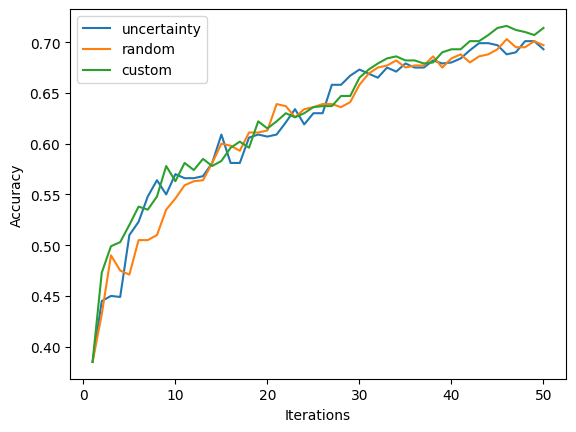

In [35]:
model = 'SVC'
for criterion in selection_criteria:
    print(f'Criterion: {criterion}')
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
    print("final accuracy: ", accuracy_scores_dict[criterion][-1])

generate_plot(accuracy_scores_dict)

Criterion: uncertainty


100%|██████████| 50/50 [00:20<00:00,  2.47it/s]


final accuracy:  0.693
Criterion: random


100%|██████████| 50/50 [00:18<00:00,  2.78it/s]


final accuracy:  0.679
Criterion: custom


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]

final accuracy:  0.714


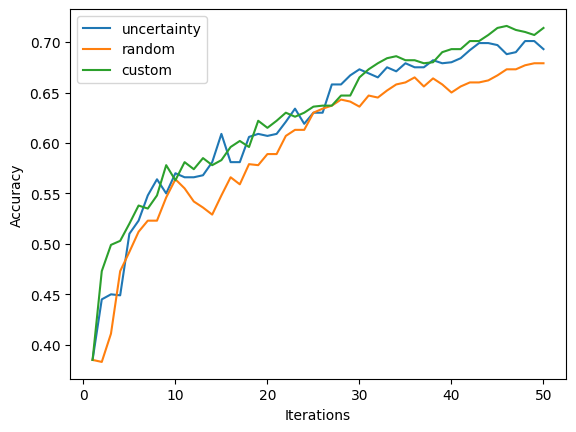

In [36]:
model = 'RandomForestClassifier'
for criterion in selection_criteria:
    print(f'Criterion: {criterion}')
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
    print("final accuracy: ", accuracy_scores_dict[criterion][-1])

generate_plot(accuracy_scores_dict)

Criterion: uncertainty


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


final accuracy:  0.693
Criterion: random


100%|██████████| 50/50 [00:18<00:00,  2.73it/s]


final accuracy:  0.69
Criterion: custom


100%|██████████| 50/50 [00:21<00:00,  2.30it/s]

final accuracy:  0.714


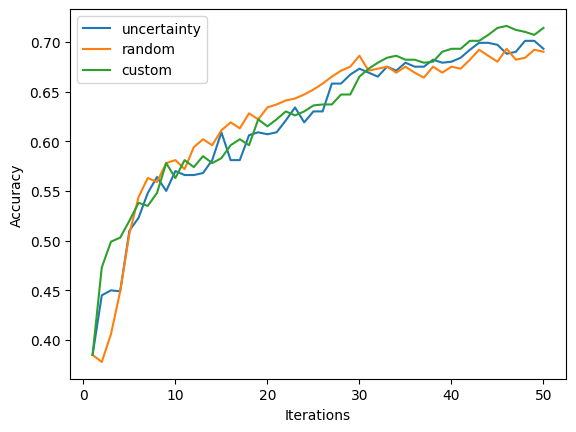

In [37]:
model = 'LogisticRegression'
for criterion in selection_criteria:
    print(f'Criterion: {criterion}')
    AL_class = ActiveLearningPipeline(model=model,
                                      test_indices=test_indices,
                                      available_pool_indices=available_pool_indices,
                                      train_indices=train_indices,
                                      selection_criterion=criterion,
                                      iterations=iterations,
                                      budget_per_iter=budget_per_iter,
                                      nodes_df_path=nodes_df_path,
                                      subject_mapping_path=subject_mapping_path)
    accuracy_scores_dict[criterion] = AL_class.run_pipeline()
    print("final accuracy: ", accuracy_scores_dict[criterion][-1])

generate_plot(accuracy_scores_dict)

## Compare Parameters

In [70]:
models = ['SVC', 'RandomForestClassifier', 'LogisticRegression']
experiments_tuples = [(19,30),(39,15),(59,10)] #(budget, iterations)

def explore_selection_criteria(criterion):
    experiment_dict = {}

    for model in models:
        print(f'### Model: {model} ###')

        for i, (budget, iterations) in enumerate(experiments_tuples):
            print(f'Budget: {budget}, Iterations: {iterations}')
            
            AL_class = ActiveLearningPipeline(model=model,
                                              test_indices=test_indices,
                                              available_pool_indices=available_pool_indices,
                                              train_indices=train_indices,
                                              selection_criterion=criterion,
                                              iterations=iterations,
                                              budget_per_iter=budget,
                                              nodes_df_path=nodes_df_path,
                                              subject_mapping_path=subject_mapping_path)
            experiment_dict[(model, i)] = AL_class.run_pipeline()
            print("final accuracy: ", experiment_dict[(model, i)][-1])

    return experiment_dict

In [71]:
### Random sampling:
random_dict = explore_selection_criteria('random')

### Model: SVC ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:12<00:00,  2.36it/s]


final accuracy:  0.682
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:07<00:00,  2.04it/s]


final accuracy:  0.684
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:03<00:00,  2.55it/s]


final accuracy:  0.686
### Model: RandomForestClassifier ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:12<00:00,  2.44it/s]


final accuracy:  0.699
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:05<00:00,  2.71it/s]


final accuracy:  0.684
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


final accuracy:  0.677
### Model: LogisticRegression ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:11<00:00,  2.58it/s]


final accuracy:  0.682
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:05<00:00,  2.73it/s]


final accuracy:  0.695
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

final accuracy:  0.675


In [72]:
### Uncertainty sampling:
uncertainty_dict = explore_selection_criteria('uncertainty')

### Model: SVC ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:14<00:00,  2.06it/s]


final accuracy:  0.695
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:06<00:00,  2.17it/s]


final accuracy:  0.688
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


final accuracy:  0.699
### Model: RandomForestClassifier ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:12<00:00,  2.49it/s]


final accuracy:  0.695
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:06<00:00,  2.48it/s]


final accuracy:  0.688
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


final accuracy:  0.699
### Model: LogisticRegression ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:11<00:00,  2.50it/s]


final accuracy:  0.695
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:06<00:00,  2.33it/s]


final accuracy:  0.688
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

final accuracy:  0.699


In [73]:
### Custom sampling:
custom_dict = explore_selection_criteria('custom')

### Model: SVC ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:12<00:00,  2.43it/s]


final accuracy:  0.746
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:06<00:00,  2.30it/s]


final accuracy:  0.729
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


final accuracy:  0.733
### Model: RandomForestClassifier ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:13<00:00,  2.17it/s]


final accuracy:  0.746
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:07<00:00,  2.01it/s]


final accuracy:  0.729
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:03<00:00,  2.51it/s]


final accuracy:  0.733
### Model: LogisticRegression ###
Budget: 19, Iterations: 30


100%|██████████| 30/30 [00:13<00:00,  2.21it/s]


final accuracy:  0.746
Budget: 39, Iterations: 15


100%|██████████| 15/15 [00:07<00:00,  2.00it/s]


final accuracy:  0.729
Budget: 59, Iterations: 10


100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

final accuracy:  0.733


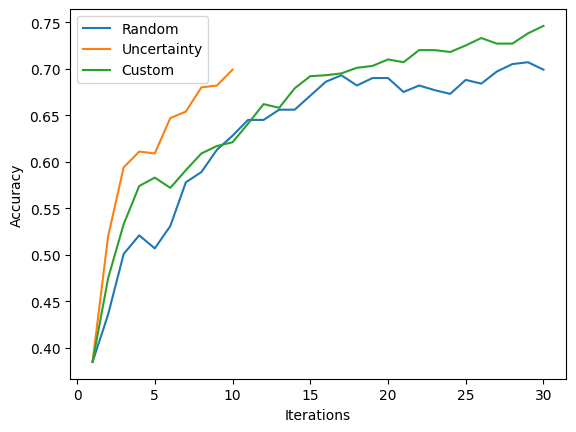

In [77]:
### plot only best random forest models:

rand_forest = random_dict[('RandomForestClassifier', 0)]
uncertainty_forest = uncertainty_dict[('RandomForestClassifier', 2)]
custom_forest = custom_dict[('RandomForestClassifier', 0)]

plt.plot(range(1, len(rand_forest) + 1), rand_forest, label='Random')
plt.plot(range(1, len(uncertainty_forest) + 1), uncertainty_forest, label='Uncertainty')
plt.plot(range(1, len(custom_forest) + 1), custom_forest, label='Custom')

plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()